In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import filterpy.kalman

### Construction of the original spiral

In [2]:
R = 4.125    # Radius of the spiral (8.25 meter diameter, so radius = 4.125 meters)
N = 3.30     # Number of turns
H = 13       # Total height (13 meters)
T = 1300     # Number of steps (adjustable)

# Calculate the spiral points
original_spiral = np.array([[-R * np.cos(i * (2 * np.pi * N) / T),  R * np.sin(i * (2 * np.pi * N) / T), (i / T) * H] for i in range(T)])

### Data Upload

In [3]:
df = pd.read_csv("sensor_data.csv")
df["v_x"] = df["omega_x"]*R
df["v_y"] = df["omega_y"]*R
df["v_z"] = df["omega_z"]*R
df.head()

,a_x,a_y,a_z,m_x,m_y,m_z,omega_x,omega_y,omega_z,g_x,g_y,g_z,Pressure,Temperature,Timestamp,v_x,v_y,v_z
0,-5.20,-3.31,9.24,21.25,-9.19,-38.38,25.06,15.50,-55.13,-3.49,-2.88,8.69,102804.18,23.27,2024-11-12 16:34:33,103.37250,63.93750,-227.41125
1,-5.41,-2.49,8.24,22.19,-8.88,-38.69,38.06,25.69,-31.62,-3.59,-2.74,8.69,102804.01,23.27,2024-11-12 16:34:33,156.99750,105.97125,-130.43250
2,-5.07,-2.36,7.31,23.69,-9.69,-37.88,9.38,-9.00,0.06,-3.65,-2.42,8.76,102804.00,23.27,2024-11-12 16:34:33,38.69250,-37.12500,0.24750
3,-6.35,-0.48,8.99,24.06,-10.88,-35.88,43.25,15.56,-2.75,-3.66,-2.15,8.83,102804.19,23.27,2024-11-12 16:34:33,178.40625,64.18500,-11.34375
4,-5.54,-1.84,9.93,25.25,-11.56,-35.88,33.44,1.37,-4.00,-3.61,-2.57,8.74,102804.32,23.26,2024-11-12 16:34:33,137.94000,5.65125,-16.50000


In the very simple terms, Kalman filter is an optimal estimation algorithm. It is used when we cannot really see or measure something directly. In this very case, we are predicting the somebody's position based on the information on their initial position $(x,y,z)^T$. Based on those we are also measuring $(v_x,v_y,v_z)$.

The Kalman filter works in two steps:

1. **predict**: during this step we are predicting what is going to be the position at the next sample point
2. **update**: compares the estimate from **predict** with the measurement and updates it based on that, also the filter keeps the information on the estimate uncertainty

And we basically have a while loop with those.

    while(walking):
        extimate = predict(next position)
        update(estimate)

In [4]:
kf_x = filterpy.kalman.KalmanFilter(dim_x=3,dim_z=1)
S, v, ab = 0, 0, 0
T, dt = 0, 0
kf_x.x = np.array([
    [float(S)],
    [float(v)],
    [float(ab)]
])
kf_x.F = np.array([
    [1, dt, -0.5*T**2],
    [0, 1, -T],
    [0, 0, T]
])
kf_x.H = np.array([
    [1, 0, 0]
])
s_std, v_std, ab_std = 0.01, 0.1, 0.02
kf_x.P = np.array([
    [s_std**2, s_std*v_std, s_std*ab_std],
    [v_std*s_std, v_std**2, v_std*ab_std],
    [ab_std*s_std, ab_std*v_std, ab_std**2]
])
Q_std, R_std = 0.01, 0.1
kf_x.Q = np.array([
    [0.25*T**4 * Q_std**2, 0.5*T**3 * Q_std**2, 0],
    [0.5*T**3 * Q_std**2, T**2 * Q_std**2, 0],
    [0, 0, 0]
])
kf_x.R = np.array([[R_std]])

In [5]:
kf_y = filterpy.kalman.KalmanFilter(dim_x=3,dim_z=1)
S, v, ab = 0, 0, 0
T, dt = 0, 0
kf_y.x = np.array([
    [float(S)],
    [float(v)],
    [float(ab)]
])
kf_y.F = np.array([
    [1, dt, -0.5*T**2],
    [0, 1, -T],
    [0, 0, T]
])
kf_y.H = np.array([
    [1, 0, 0]
])
s_std, v_std, ab_std = 0.01, 0.1, 0.02
kf_y.P = np.array([
    [s_std**2, s_std*v_std, s_std*ab_std],
    [v_std*s_std, v_std**2, v_std*ab_std],
    [ab_std*s_std, ab_std*v_std, ab_std**2]
])
Q_std, R_std = 0.01, 0.1
kf_y.Q = np.array([
    [0.25*T**4 * Q_std**2, 0.5*T**3 * Q_std**2, 0],
    [0.5*T**3 * Q_std**2, T**2 * Q_std**2, 0],
    [0, 0, 0]
])
kf_y.R = np.array([[R_std]])

In [6]:
kf_z = filterpy.kalman.KalmanFilter(dim_x=3,dim_z=1)
S, v, ab = 0, 0, 0
T, dt = 0, 0
kf_z.x = np.array([
    [float(S)],
    [float(v)],
    [float(ab)]
])
kf_z.F = np.array([
    [1, dt, -0.5*T**2],
    [0, 1, -T],
    [0, 0, T]
])
kf_z.H = np.array([
    [1, 0, 0]
])
s_std, v_std, ab_std = 0.01, 0.1, 0.02
kf_z.P = np.array([
    [s_std**2, s_std*v_std, s_std*ab_std],
    [v_std*s_std, v_std**2, v_std*ab_std],
    [ab_std*s_std, ab_std*v_std, ab_std**2]
])
Q_std, R_std = 0.01, 0.1
kf_z.Q = np.array([
    [0.25*T**4 * Q_std**2, 0.5*T**3 * Q_std**2, 0],
    [0.5*T**3 * Q_std**2, T**2 * Q_std**2, 0],
    [0, 0, 0]
])
kf_z.R = np.array([[R_std]])

In [7]:
measurements_x, measurements_y, measurements_z = df["a_x"], df["a_y"], df["a_z"]
position_x, position_y, position_z = [], [], []

for ax,ay,az in zip(measurements_x, measurements_y, measurements_z):
    # flow: read -> predict -> update -> repeat
    kf_x.predict()
    kf_y.predict()
    kf_z.predict()
    kf_x.update(ax)
    kf_y.update(ay)
    kf_z.update(az)
    position_x.append(kf_x.x[0])
    position_y.append(kf_y.x[0])
    position_z.append(kf_z.x[1])
    


In [8]:
print(len(position_x))

2249


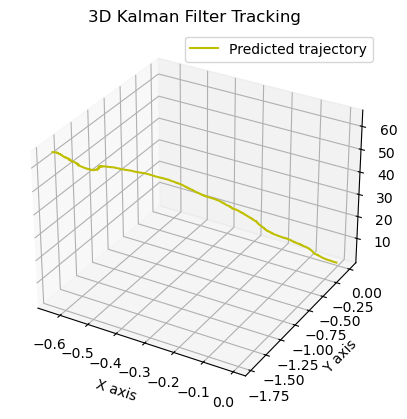

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(position_x, position_y, position_z, 'y', label='Predicted trajectory')

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_title('3D Kalman Filter Tracking')
ax.legend()
